### Settings and imports

In [1]:
from utils import retrieve_transport_plan, shift_and_mix
from visualization_module import  visualize_transport_plan, visualize_transport_distance_distribution, visualize_spectra, visualize_stacked_spectra, plot_removed_noise
from masserstein import Spectrum, NMRSpectrum, dualdeconv4, estimate_proportions
import numpy as np
import matplotlib as plt
import pulp

### Spectra generator

In [2]:
def generate_synthetic_spectrum(peaks, ppm_range=(0, 10), resolution=0.001, noise_level=0.001):
    ppm = np.arange(ppm_range[1], ppm_range[0], -resolution)
    intensity = np.zeros_like(ppm)

    for center, height, width in peaks:
        intensity += height * np.exp(-((ppm - center) ** 2) / (2 * width ** 2))

    # noise = np.random.normal(0, noise_level, size=ppm.shape)
    # intensity += noise

    return ppm, intensity

# Define peaks for two components
component1_peaks = [
    (7.5, 0.8, 0.03),
    (5.3, 0.6, 0.02),
    (3.8, 0.4, 0.015),
]

component2_peaks = [
    (8.2, 0.7, 0.02),
    (4.2, 0.4, 0.02),
    (1.0, 0.3, 0.04)
]

mixture_peaks = [
    (8.2, 0.7, 0.02),
    (6.0, 0.5, 0.03),
    (1.0, 0.3, 0.04),
    (7.5, 0.8, 0.03),
    (5.3, 0.6, 0.02),
    (2.1, 0.5, 0.025)
]

# Generate spectra
ppm, comp1_intensity = generate_synthetic_spectrum(component1_peaks)
_, comp2_intensity = generate_synthetic_spectrum(component2_peaks)
_, mixture_intensity = generate_synthetic_spectrum(mixture_peaks)

# Convert to list of (ppm, intensity)
spectrum_mixture = list(zip(ppm, mixture_intensity))
spectrum_component1 = list(zip(ppm, comp1_intensity))
spectrum_component2 = list(zip(ppm, comp2_intensity))

In [3]:
mixture_spec = NMRSpectrum(confs=spectrum_mixture)
component1_spec = NMRSpectrum(confs=spectrum_component1)
component2_spec = NMRSpectrum(confs=spectrum_component2)

kappa_mix = 0.05
kappa_comp = 0.1
spectra_objects = [component1_spec, component2_spec]
estimation = estimate_proportions(mixture_spec, [component1_spec, component2_spec], what_to_compare='area', MTD=kappa_mix, MTD_th=kappa_comp, solver=pulp.LpSolverDefault)

p0 = 1-sum(estimation['proportions'])
p0_prime = estimation['proportion_of_noise_in_components']

mixture_spec.normalize(target_value=1-p0_prime)

for i, sp in enumerate(spectra_objects):
    sp.normalize(estimation['proportions'][i])

all_confs = [
                conf
                for confs_list in [sp.confs for sp in spectra_objects]
                for conf in confs_list
            ]
weighted_sum_of_components = NMRSpectrum(confs = all_confs)

noise_in_mix_spectrum = estimation['noise']
noise_in_components = estimation['noise_in_components']

The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 is not normalized.
Normalizing component's spectrum 0.
Component's spectrum 1 is not normalized.
Normalizing component's spectrum 1.


/home/zofia/Desktop/MASTER_BIOINF/venv/lib/python3.12/site-packages/pulp/pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


### Test identity

In [4]:
transport_df, mix_confs, wsom_confs, distances, sum_noise_in_mix, sum_noise_in_mix_comp = retrieve_transport_plan(mix=mixture_spec, spectra=[mixture_spec], interesting_region = (0,10), kappa_components=kappa_comp, kappa_mixture=kappa_mix, log=False)

The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 is not normalized.
Normalizing component's spectrum 0.
Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(np.float64(0.0010000000055416791), np.float64(10.0), 0)]
Number of chunks: 1
ChunkIDs: [0]
Chunk bounds: [(np.float64(-0.09899999999445833), np.float64(10.1))]
Ion currents in chunks: [np.float64(0.9999999999999984)]
Deconvolving chunk 0
Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 1.0
Noise proportion in mixture's spectrum: 0.0
Total explanation: 1.0
Noise proportion in combination of components' spectra: -0.0


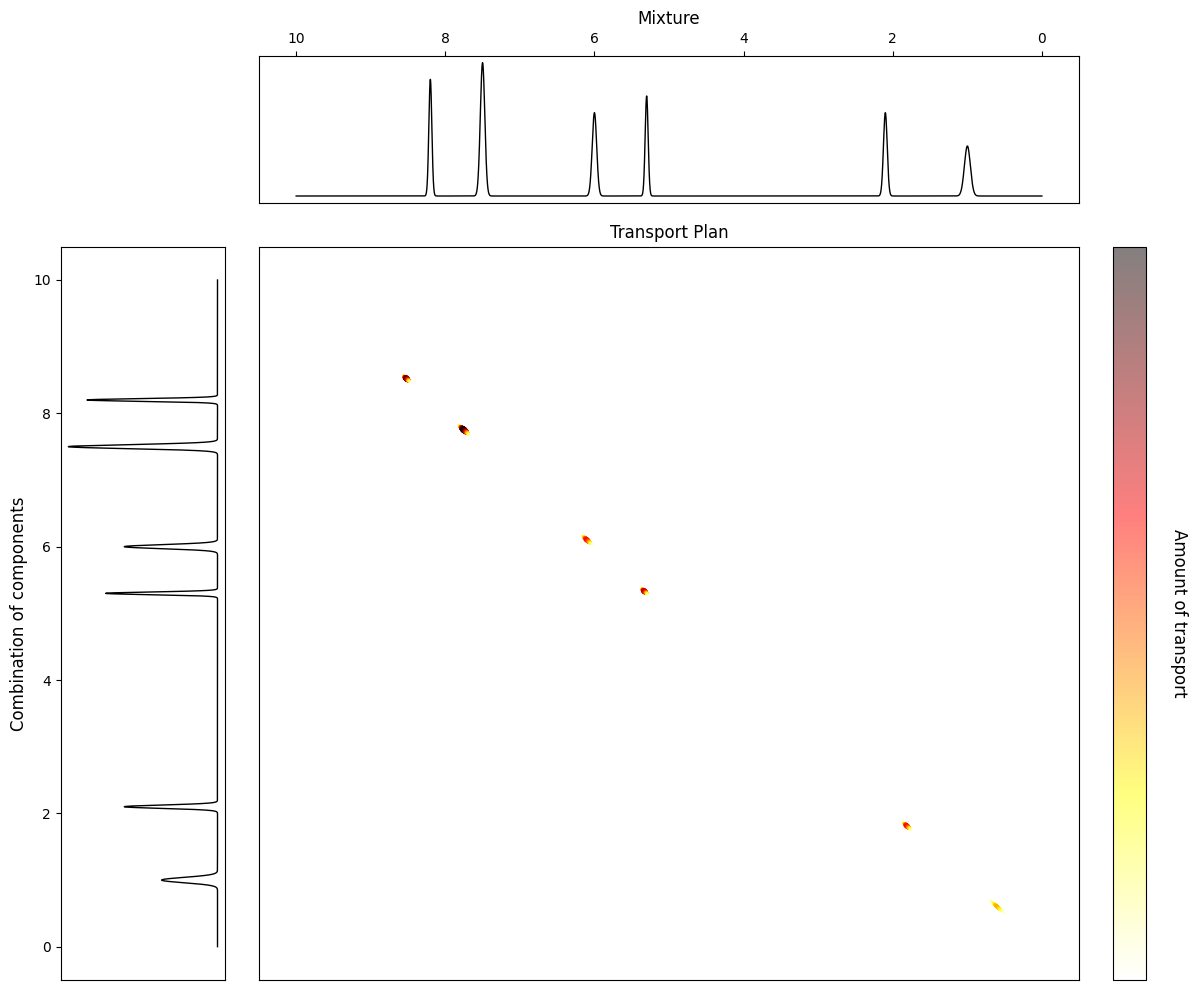

In [5]:
visualize_transport_plan(transport_df, mix_confs, wsom_confs, experiment_name=None, lower_lim=None, upper_lim=None, figures_path=None, variant=None, alpha=0.5)

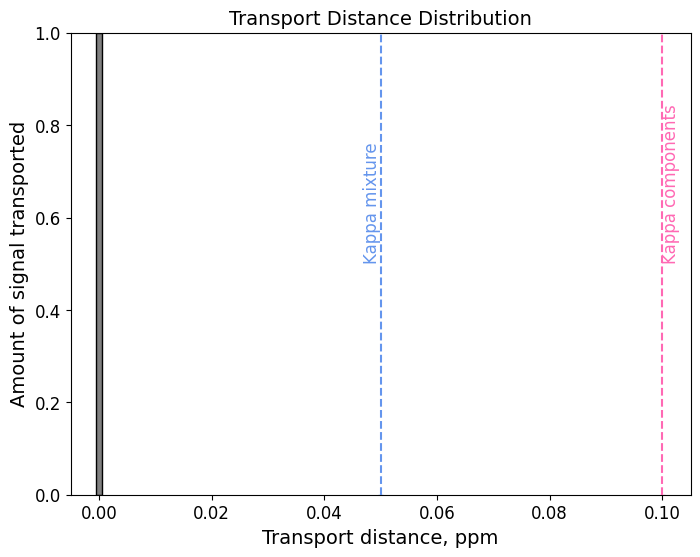

In [6]:
visualize_transport_distance_distribution(sum_noise_in_mix, sum_noise_in_mix_comp, distances, kappa_comp, kappa_mix)

### More complex case

In [13]:
# Utility: Slight random shift
def shift(peaks, shift_range=0.5):
    return [(ppm + np.random.uniform(-shift_range, shift_range), intensity, width) for ppm, intensity, width in peaks]

# Components with slight shifts
component1_peaks = shift([
    (7.5, 0.8, 0.03),
    (5.3, 0.6, 0.02),
    (3.8, 0.4, 0.015),
])

component2_peaks = shift([
    (8.2, 0.7, 0.02),
    (4.2, 0.4, 0.02),
    (1.0, 0.3, 0.04)
])

component3_peaks = shift([
    (6.3, 0.5, 0.01),
    (3.2, 0.6, 0.015),
    (2.0, 0.3, 0.01)
])

component4_peaks = shift([
    (9.0, 0.9, 0.02),
    (6.8, 0.6, 0.025),
    (0.8, 0.4, 0.03)
])

# Combine all component peaks for the mixture
all_component_peaks = component1_peaks + component2_peaks + component3_peaks + component4_peaks

# Add noisy (random) peaks to the mixture
num_noise_peaks = 3
noise_peaks = [
    (np.round(np.random.uniform(0.5, 9.5), 2), np.round(np.random.uniform(0.1, 0.5), 2), np.round(np.random.uniform(0.01, 0.03), 3))
    for _ in range(num_noise_peaks)
]

# Final mixture peaks
mixture_peaks = all_component_peaks + noise_peaks

In [14]:
# Generate spectra
ppm, comp1_intensity = generate_synthetic_spectrum(component1_peaks)
_, comp2_intensity = generate_synthetic_spectrum(component2_peaks)
_, comp3_intensity = generate_synthetic_spectrum(component3_peaks)
_, comp4_intensity = generate_synthetic_spectrum(component4_peaks)
_, mixture_intensity = generate_synthetic_spectrum(mixture_peaks)

# Convert to list of (ppm, intensity)
spectrum_mixture = list(zip(ppm, mixture_intensity))
spectrum_component1 = list(zip(ppm, comp1_intensity))
spectrum_component2 = list(zip(ppm, comp2_intensity))
spectrum_component3 = list(zip(ppm, comp3_intensity))
spectrum_component4 = list(zip(ppm, comp4_intensity))

In [15]:
mixture_spec = NMRSpectrum(confs=spectrum_mixture)
component1_spec = NMRSpectrum(confs=spectrum_component1)
component2_spec = NMRSpectrum(confs=spectrum_component2)
component3_spec = NMRSpectrum(confs=spectrum_component3)
component4_spec = NMRSpectrum(confs=spectrum_component4)

kappa_mix = 0.05
kappa_comp = 0.1
spectra_objects = [component1_spec, component2_spec, component3_spec, component4_spec]
estimation = estimate_proportions(mixture_spec, [component1_spec, component2_spec, component3_spec, component4_spec], what_to_compare='area', MTD=kappa_mix, MTD_th=kappa_comp, solver=pulp.LpSolverDefault)

p0 = 1-sum(estimation['proportions'])
p0_prime = estimation['proportion_of_noise_in_components']

mixture_spec.normalize(target_value=1-p0_prime)

for i, sp in enumerate(spectra_objects):
    sp.normalize(estimation['proportions'][i])

all_confs = [
                conf
                for confs_list in [sp.confs for sp in spectra_objects]
                for conf in confs_list
            ]
weighted_sum_of_components = NMRSpectrum(confs = all_confs)

noise_in_mix_spectrum = estimation['noise']
noise_in_components = estimation['noise_in_components']

The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 is not normalized.
Normalizing component's spectrum 0.
Component's spectrum 1 is not normalized.
Normalizing component's spectrum 1.
Component's spectrum 2 is not normalized.
Normalizing component's spectrum 2.
Component's spectrum 3 is not normalized.
Normalizing component's spectrum 3.


In [16]:
transport_df, mix_confs, wsom_confs, distances, sum_noise_in_mix, sum_noise_in_mix_comp = retrieve_transport_plan(mix=mixture_spec, spectra=[component1_spec, component2_spec, component3_spec, component4_spec], interesting_region = (0,10), kappa_components=kappa_comp, kappa_mixture=kappa_mix, log=False)

The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 is not normalized.
Normalizing component's spectrum 0.
Component's spectrum 1 is not normalized.
Normalizing component's spectrum 1.
Component's spectrum 2 is not normalized.
Normalizing component's spectrum 2.
Component's spectrum 3 is not normalized.
Normalizing component's spectrum 3.
Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(np.float64(0.0010000000055416791), np.float64(10.0), 0), (np.float64(0.0010000000055416791), np.float64(10.0), 1), (np.float64(0.0010000000055416791), np.float64(10.0), 2), (np.float64(0.0010000000055416791), np.float64(10.0), 3)]
Number of chunks: 1
ChunkIDs: [0, 0, 0, 0]
Chunk bounds: [(np.float64(-0.09899999999445833), np.float64(10.1))]
Ion currents in chunks: [np.float64(0.999999999999999)]
Deconvolving chunk 0
Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.87532116
Noise

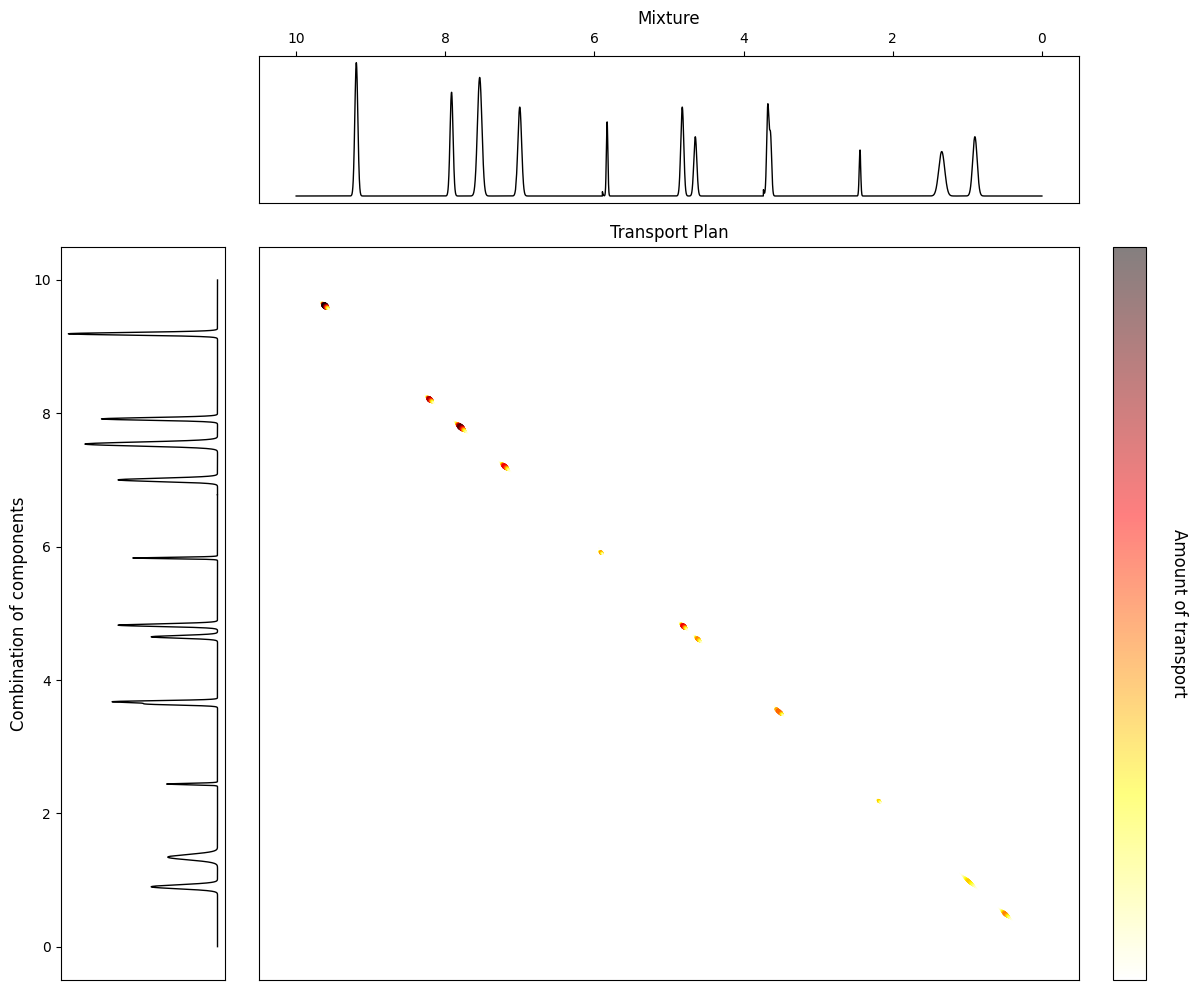

In [17]:
visualize_transport_plan(transport_df, mix_confs, wsom_confs, experiment_name=None, lower_lim=None, upper_lim=None, figures_path=None, variant=None, alpha=0.5)

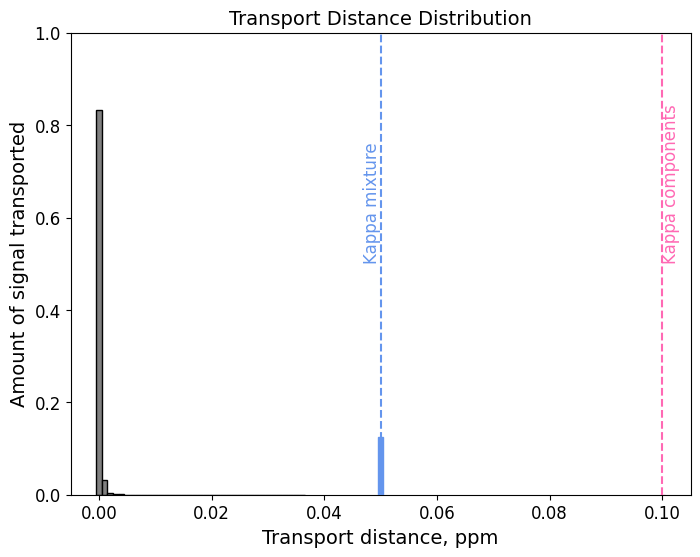

In [18]:
visualize_transport_distance_distribution(sum_noise_in_mix, sum_noise_in_mix_comp, distances, kappa_comp, kappa_mix)